In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
torch.cuda.current_device()

0

In [16]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [17]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [188]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 2))
fixed_data, fixed_target = next(iter(test_loader))

In [19]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [20]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [21]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [22]:
class Net(nn.Module):
    def __init__(self, latent_size=32, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(h)
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
            self._loss = F.mse_loss(output, target, reduction='mean')
        else:
            self.KLD = KLD.sum()
            self._loss = F.mse_loss(output, target, reduction='sum')
        
        return self._loss + self.gamma*self.KLD

In [23]:
models = {'VAE2': Net(2, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [24]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [25]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.numpy()
            fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses VAE2: 1.3626
Train Epoch: 1 [10000/50000 (20%)]	Losses VAE2: 0.5969
Train Epoch: 1 [20000/50000 (40%)]	Losses VAE2: 0.4992
Train Epoch: 1 [30000/50000 (60%)]	Losses VAE2: 0.4809
Train Epoch: 1 [40000/50000 (80%)]	Losses VAE2: 0.4448
Train Epoch: 1 [50000/50000 (100%)]	Losses VAE2: 0.4170


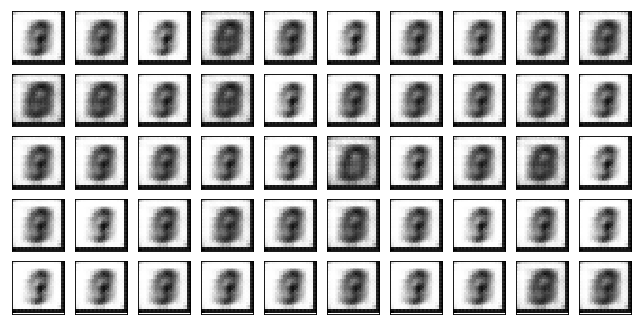

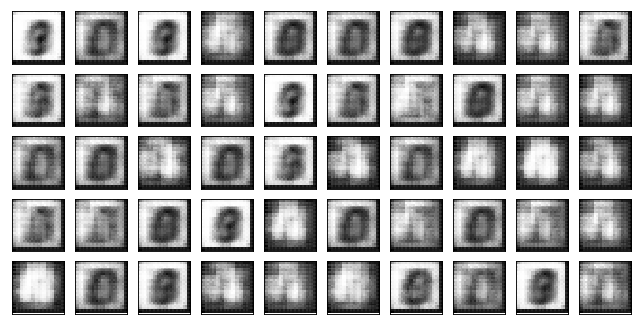

Test losses: VAE2: 0.4209/2.5102
Train Epoch: 2 [0/50000 (0%)]	Losses VAE2: 0.4320
Train Epoch: 2 [10000/50000 (20%)]	Losses VAE2: 0.3799
Train Epoch: 2 [20000/50000 (40%)]	Losses VAE2: 0.3754
Train Epoch: 2 [30000/50000 (60%)]	Losses VAE2: 0.3519
Train Epoch: 2 [40000/50000 (80%)]	Losses VAE2: 0.3227
Train Epoch: 2 [50000/50000 (100%)]	Losses VAE2: 0.2910


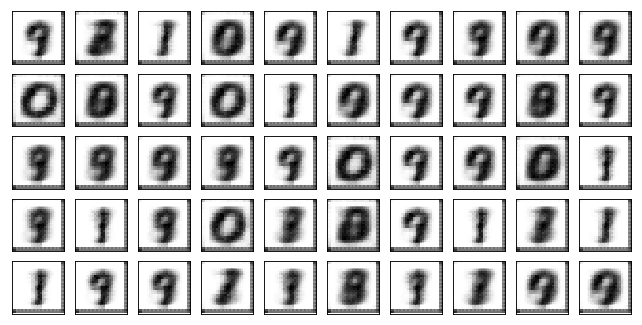

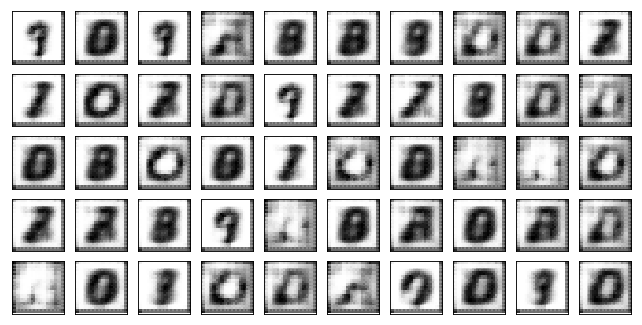

Test losses: VAE2: 0.2876/2.8951
Train Epoch: 3 [0/50000 (0%)]	Losses VAE2: 0.2866
Train Epoch: 3 [10000/50000 (20%)]	Losses VAE2: 0.2887
Train Epoch: 3 [20000/50000 (40%)]	Losses VAE2: 0.2672
Train Epoch: 3 [30000/50000 (60%)]	Losses VAE2: 0.2608
Train Epoch: 3 [40000/50000 (80%)]	Losses VAE2: 0.2413
Train Epoch: 3 [50000/50000 (100%)]	Losses VAE2: 0.2324


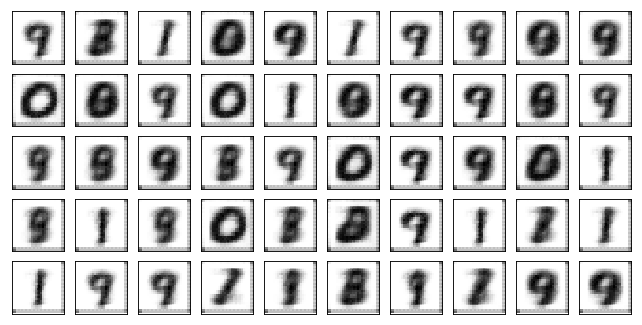

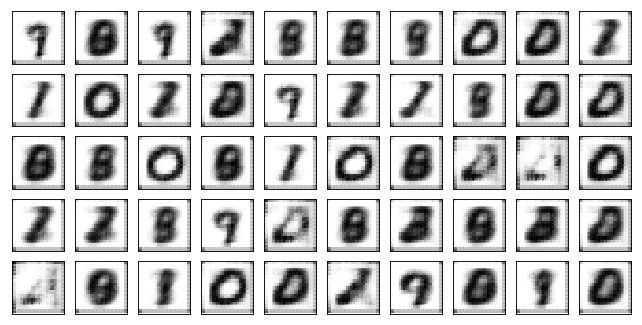

Test losses: VAE2: 0.2329/2.9335
Train Epoch: 4 [0/50000 (0%)]	Losses VAE2: 0.2374
Train Epoch: 4 [10000/50000 (20%)]	Losses VAE2: 0.2242
Train Epoch: 4 [20000/50000 (40%)]	Losses VAE2: 0.2316
Train Epoch: 4 [30000/50000 (60%)]	Losses VAE2: 0.2071
Train Epoch: 4 [40000/50000 (80%)]	Losses VAE2: 0.2303
Train Epoch: 4 [50000/50000 (100%)]	Losses VAE2: 0.2320


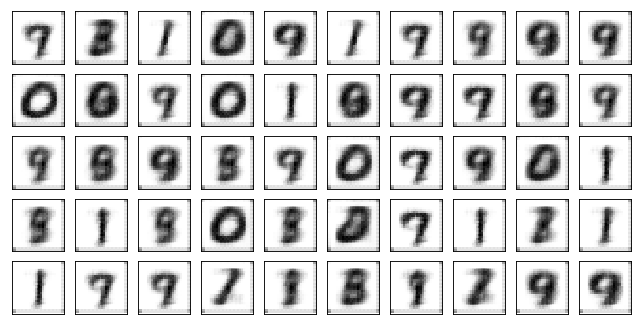

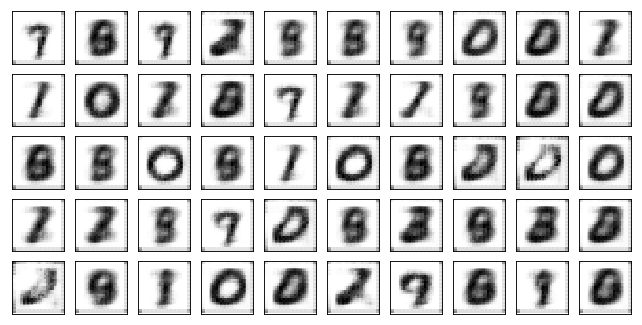

Test losses: VAE2: 0.2148/3.0516
Train Epoch: 5 [0/50000 (0%)]	Losses VAE2: 0.2248
Train Epoch: 5 [10000/50000 (20%)]	Losses VAE2: 0.1865
Train Epoch: 5 [20000/50000 (40%)]	Losses VAE2: 0.2082
Train Epoch: 5 [30000/50000 (60%)]	Losses VAE2: 0.2259
Train Epoch: 5 [40000/50000 (80%)]	Losses VAE2: 0.2010
Train Epoch: 5 [50000/50000 (100%)]	Losses VAE2: 0.2167


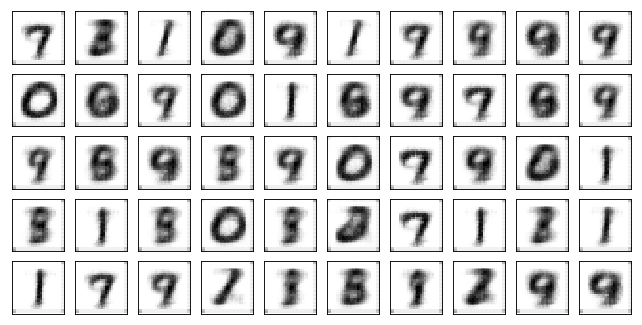

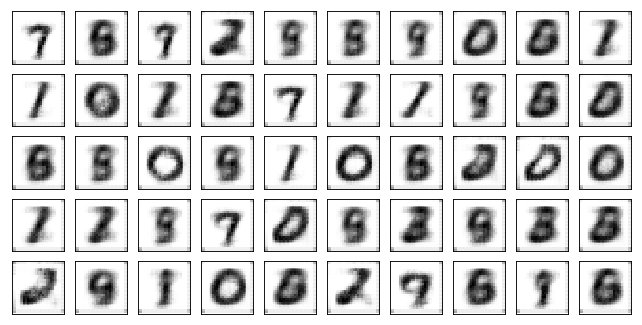

Test losses: VAE2: 0.2051/3.1309
Train Epoch: 6 [0/50000 (0%)]	Losses VAE2: 0.2287
Train Epoch: 6 [10000/50000 (20%)]	Losses VAE2: 0.2093
Train Epoch: 6 [20000/50000 (40%)]	Losses VAE2: 0.2326
Train Epoch: 6 [30000/50000 (60%)]	Losses VAE2: 0.2115
Train Epoch: 6 [40000/50000 (80%)]	Losses VAE2: 0.2211
Train Epoch: 6 [50000/50000 (100%)]	Losses VAE2: 0.2342


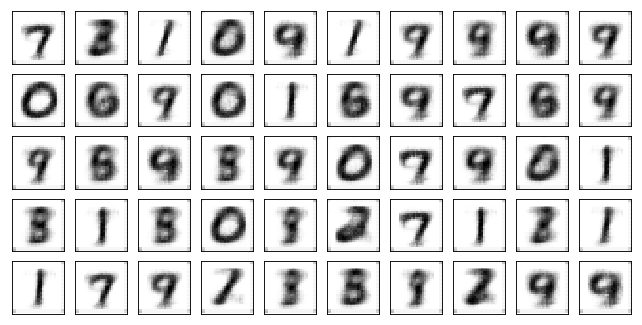

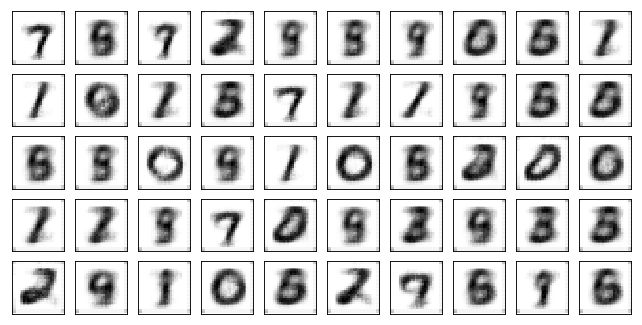

Test losses: VAE2: 0.1992/3.3793
Train Epoch: 7 [0/50000 (0%)]	Losses VAE2: 0.2178
Train Epoch: 7 [10000/50000 (20%)]	Losses VAE2: 0.2077
Train Epoch: 7 [20000/50000 (40%)]	Losses VAE2: 0.2116
Train Epoch: 7 [30000/50000 (60%)]	Losses VAE2: 0.2019
Train Epoch: 7 [40000/50000 (80%)]	Losses VAE2: 0.2150
Train Epoch: 7 [50000/50000 (100%)]	Losses VAE2: 0.1912


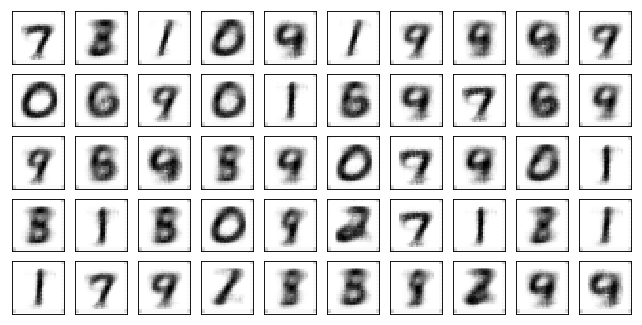

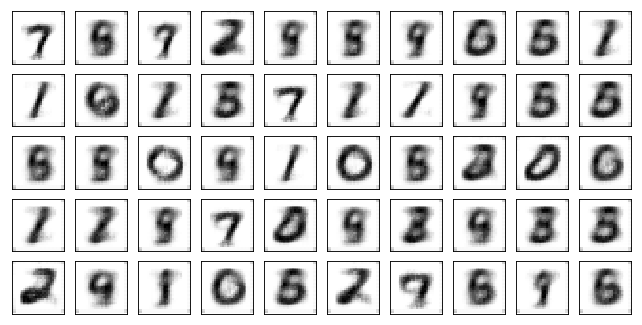

Test losses: VAE2: 0.1951/3.3852
Train Epoch: 8 [0/50000 (0%)]	Losses VAE2: 0.2236
Train Epoch: 8 [10000/50000 (20%)]	Losses VAE2: 0.1981
Train Epoch: 8 [20000/50000 (40%)]	Losses VAE2: 0.2166
Train Epoch: 8 [30000/50000 (60%)]	Losses VAE2: 0.2015
Train Epoch: 8 [40000/50000 (80%)]	Losses VAE2: 0.2181
Train Epoch: 8 [50000/50000 (100%)]	Losses VAE2: 0.1747


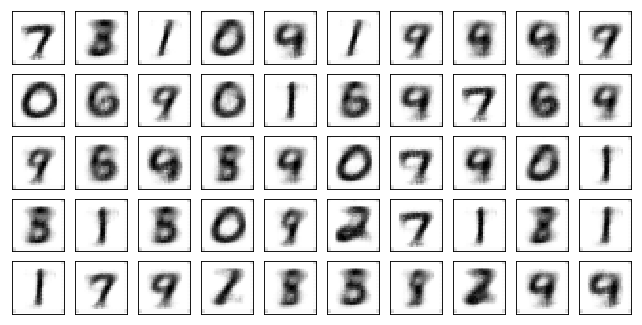

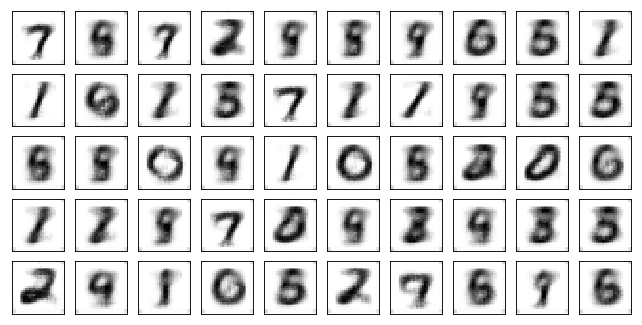

Test losses: VAE2: 0.1920/3.5730
Train Epoch: 9 [0/50000 (0%)]	Losses VAE2: 0.1828
Train Epoch: 9 [10000/50000 (20%)]	Losses VAE2: 0.1886
Train Epoch: 9 [20000/50000 (40%)]	Losses VAE2: 0.2094
Train Epoch: 9 [30000/50000 (60%)]	Losses VAE2: 0.2042
Train Epoch: 9 [40000/50000 (80%)]	Losses VAE2: 0.1916
Train Epoch: 9 [50000/50000 (100%)]	Losses VAE2: 0.1874


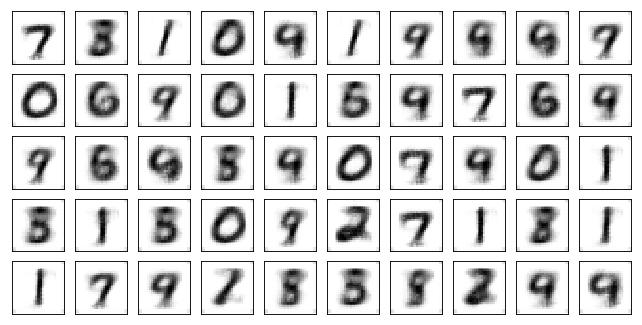

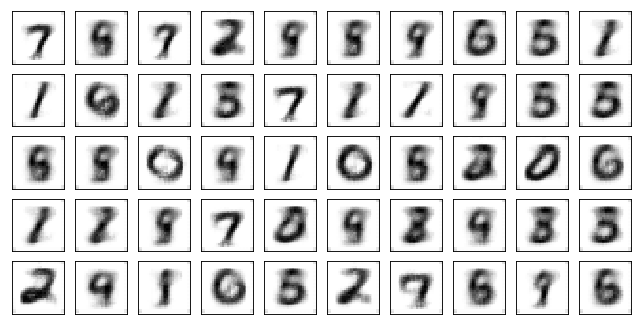

Test losses: VAE2: 0.1897/3.5839
Train Epoch: 10 [0/50000 (0%)]	Losses VAE2: 0.2020
Train Epoch: 10 [10000/50000 (20%)]	Losses VAE2: 0.1887
Train Epoch: 10 [20000/50000 (40%)]	Losses VAE2: 0.1938
Train Epoch: 10 [30000/50000 (60%)]	Losses VAE2: 0.2078
Train Epoch: 10 [40000/50000 (80%)]	Losses VAE2: 0.1941
Train Epoch: 10 [50000/50000 (100%)]	Losses VAE2: 0.1990


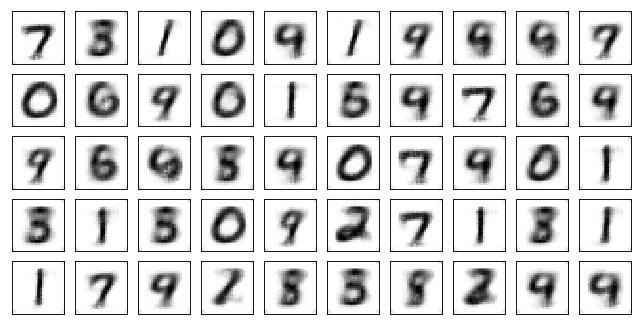

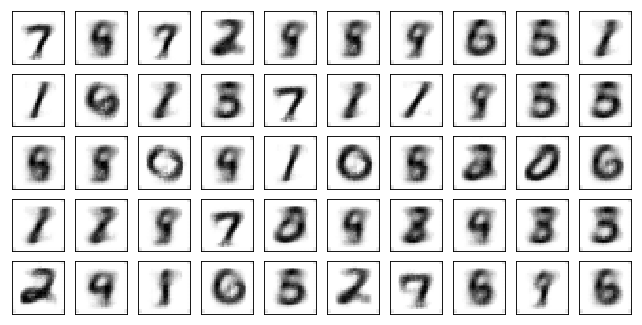

Test losses: VAE2: 0.1876/3.6951
Train Epoch: 11 [0/50000 (0%)]	Losses VAE2: 0.1809
Train Epoch: 11 [10000/50000 (20%)]	Losses VAE2: 0.1980
Train Epoch: 11 [20000/50000 (40%)]	Losses VAE2: 0.1861
Train Epoch: 11 [30000/50000 (60%)]	Losses VAE2: 0.1999
Train Epoch: 11 [40000/50000 (80%)]	Losses VAE2: 0.2004
Train Epoch: 11 [50000/50000 (100%)]	Losses VAE2: 0.2149


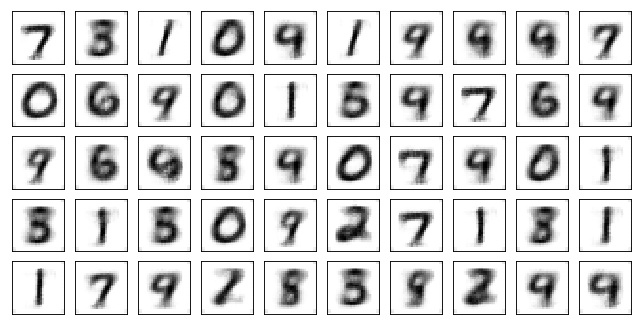

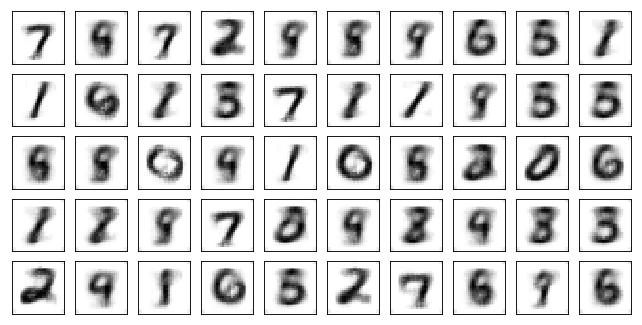

Test losses: VAE2: 0.1861/3.6944
Train Epoch: 12 [0/50000 (0%)]	Losses VAE2: 0.1856
Train Epoch: 12 [10000/50000 (20%)]	Losses VAE2: 0.2007
Train Epoch: 12 [20000/50000 (40%)]	Losses VAE2: 0.1824
Train Epoch: 12 [30000/50000 (60%)]	Losses VAE2: 0.1943
Train Epoch: 12 [40000/50000 (80%)]	Losses VAE2: 0.2009
Train Epoch: 12 [50000/50000 (100%)]	Losses VAE2: 0.1990


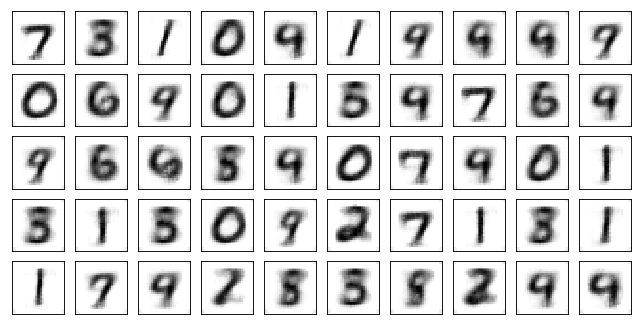

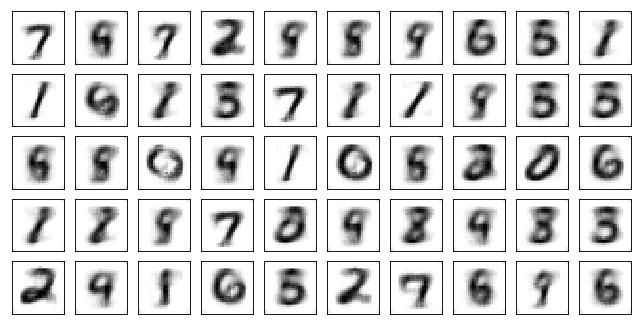

Test losses: VAE2: 0.1848/3.6796
Train Epoch: 13 [0/50000 (0%)]	Losses VAE2: 0.1887
Train Epoch: 13 [10000/50000 (20%)]	Losses VAE2: 0.2234
Train Epoch: 13 [20000/50000 (40%)]	Losses VAE2: 0.1986
Train Epoch: 13 [30000/50000 (60%)]	Losses VAE2: 0.2146
Train Epoch: 13 [40000/50000 (80%)]	Losses VAE2: 0.1932
Train Epoch: 13 [50000/50000 (100%)]	Losses VAE2: 0.1959


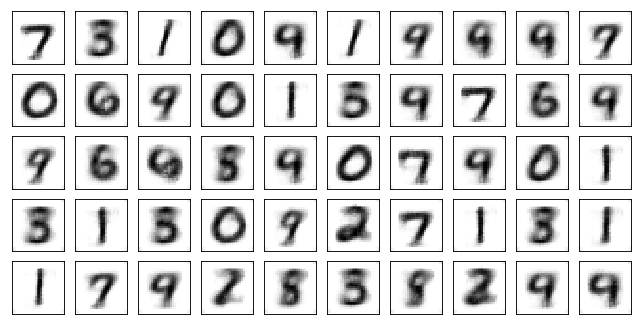

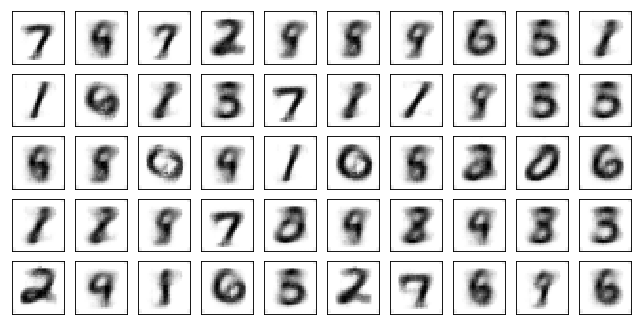

Test losses: VAE2: 0.1836/3.7942
Train Epoch: 14 [0/50000 (0%)]	Losses VAE2: 0.1756
Train Epoch: 14 [10000/50000 (20%)]	Losses VAE2: 0.1932
Train Epoch: 14 [20000/50000 (40%)]	Losses VAE2: 0.2021
Train Epoch: 14 [30000/50000 (60%)]	Losses VAE2: 0.1811
Train Epoch: 14 [40000/50000 (80%)]	Losses VAE2: 0.1775
Train Epoch: 14 [50000/50000 (100%)]	Losses VAE2: 0.1673


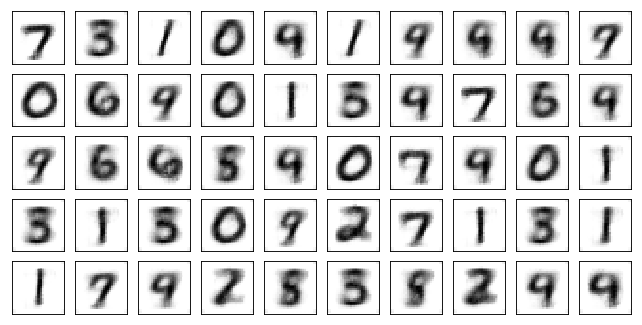

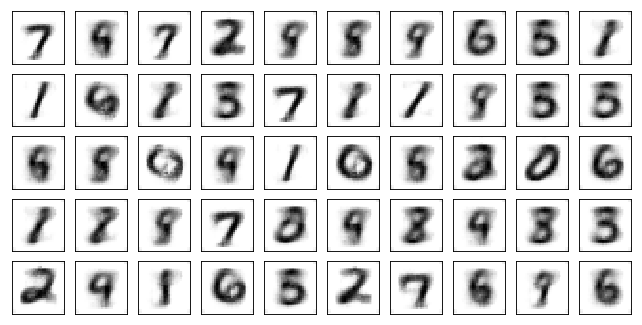

Test losses: VAE2: 0.1826/3.8234
Train Epoch: 15 [0/50000 (0%)]	Losses VAE2: 0.1830
Train Epoch: 15 [10000/50000 (20%)]	Losses VAE2: 0.1871
Train Epoch: 15 [20000/50000 (40%)]	Losses VAE2: 0.1778
Train Epoch: 15 [30000/50000 (60%)]	Losses VAE2: 0.1859
Train Epoch: 15 [40000/50000 (80%)]	Losses VAE2: 0.1830
Train Epoch: 15 [50000/50000 (100%)]	Losses VAE2: 0.1796


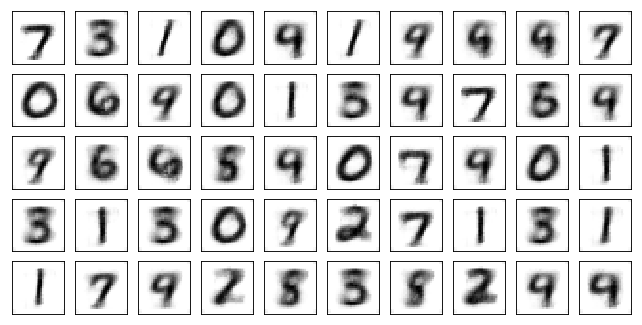

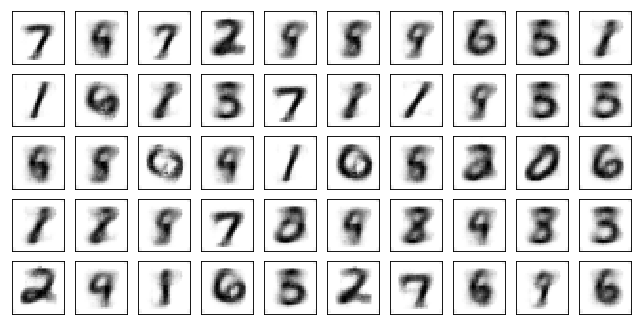

Test losses: VAE2: 0.1812/3.8414
Train Epoch: 16 [0/50000 (0%)]	Losses VAE2: 0.1814
Train Epoch: 16 [10000/50000 (20%)]	Losses VAE2: 0.1689
Train Epoch: 16 [20000/50000 (40%)]	Losses VAE2: 0.1673
Train Epoch: 16 [30000/50000 (60%)]	Losses VAE2: 0.1882
Train Epoch: 16 [40000/50000 (80%)]	Losses VAE2: 0.1849
Train Epoch: 16 [50000/50000 (100%)]	Losses VAE2: 0.2069


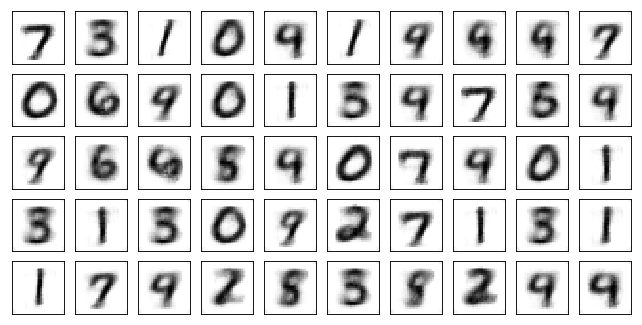

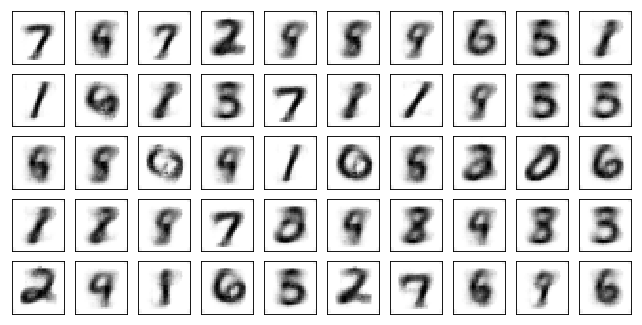

Test losses: VAE2: 0.1804/3.8301
Train Epoch: 17 [0/50000 (0%)]	Losses VAE2: 0.1709
Train Epoch: 17 [10000/50000 (20%)]	Losses VAE2: 0.1970
Train Epoch: 17 [20000/50000 (40%)]	Losses VAE2: 0.1765
Train Epoch: 17 [30000/50000 (60%)]	Losses VAE2: 0.1828
Train Epoch: 17 [40000/50000 (80%)]	Losses VAE2: 0.1690
Train Epoch: 17 [50000/50000 (100%)]	Losses VAE2: 0.1845


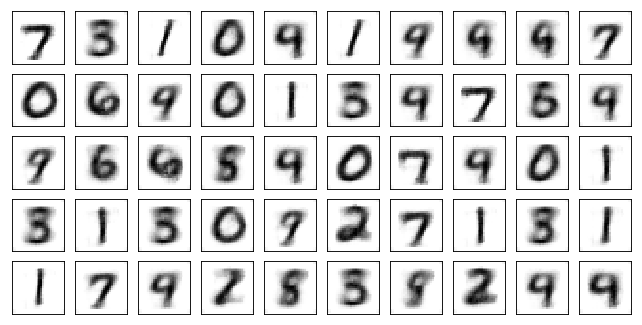

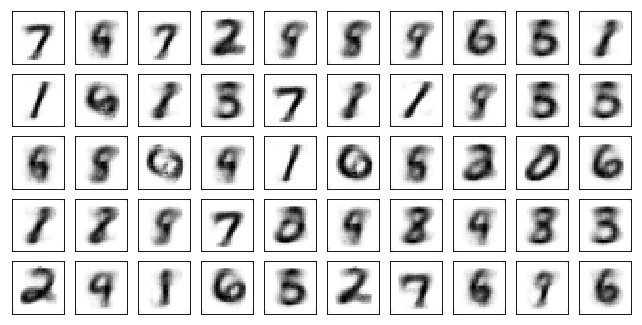

Test losses: VAE2: 0.1792/3.9263
Train Epoch: 18 [0/50000 (0%)]	Losses VAE2: 0.1834
Train Epoch: 18 [10000/50000 (20%)]	Losses VAE2: 0.1777
Train Epoch: 18 [20000/50000 (40%)]	Losses VAE2: 0.1973
Train Epoch: 18 [30000/50000 (60%)]	Losses VAE2: 0.1819
Train Epoch: 18 [40000/50000 (80%)]	Losses VAE2: 0.1893
Train Epoch: 18 [50000/50000 (100%)]	Losses VAE2: 0.1753


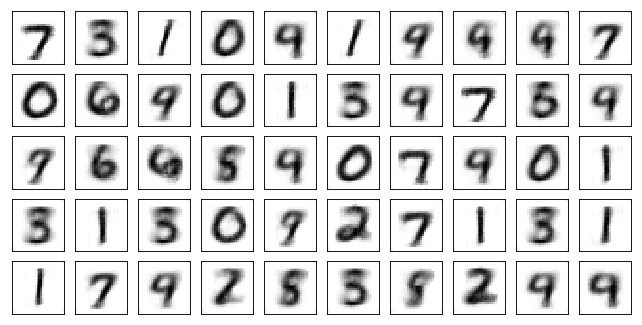

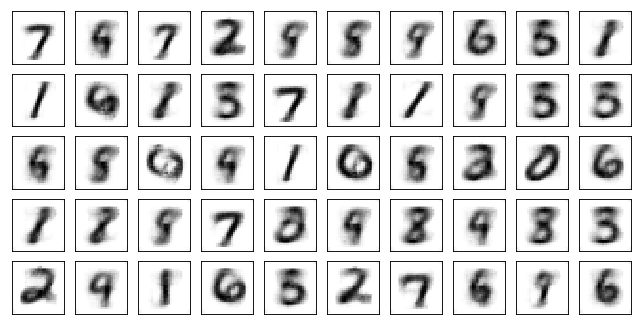

Test losses: VAE2: 0.1785/3.9980
Train Epoch: 19 [0/50000 (0%)]	Losses VAE2: 0.1677
Train Epoch: 19 [10000/50000 (20%)]	Losses VAE2: 0.1758
Train Epoch: 19 [20000/50000 (40%)]	Losses VAE2: 0.1729
Train Epoch: 19 [30000/50000 (60%)]	Losses VAE2: 0.1868
Train Epoch: 19 [40000/50000 (80%)]	Losses VAE2: 0.2080
Train Epoch: 19 [50000/50000 (100%)]	Losses VAE2: 0.1965


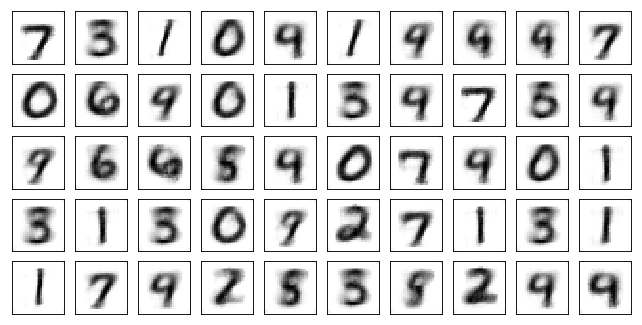

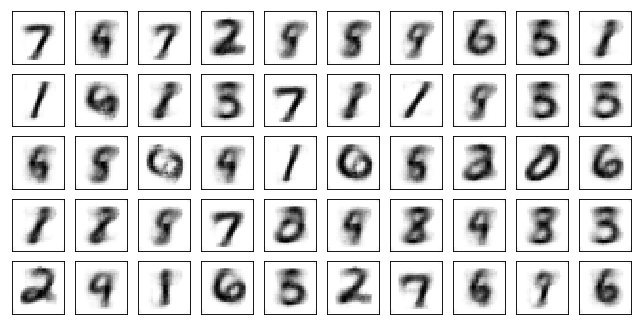

Test losses: VAE2: 0.1773/4.0473
Train Epoch: 20 [0/50000 (0%)]	Losses VAE2: 0.1832
Train Epoch: 20 [10000/50000 (20%)]	Losses VAE2: 0.1874
Train Epoch: 20 [20000/50000 (40%)]	Losses VAE2: 0.1854
Train Epoch: 20 [30000/50000 (60%)]	Losses VAE2: 0.1708
Train Epoch: 20 [40000/50000 (80%)]	Losses VAE2: 0.1778
Train Epoch: 20 [50000/50000 (100%)]	Losses VAE2: 0.1855


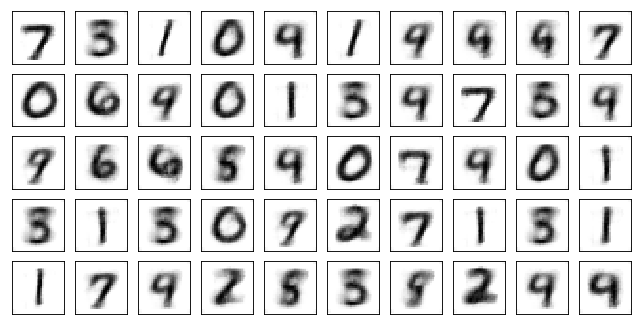

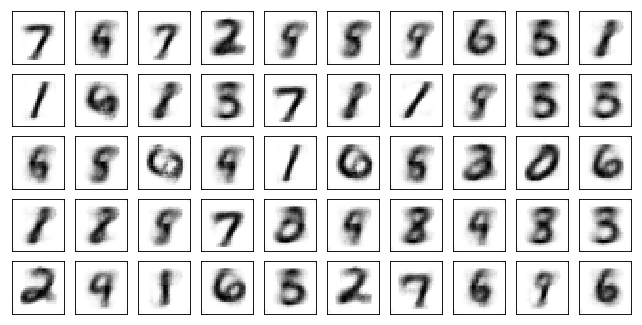

Test losses: VAE2: 0.1769/4.0703
Train Epoch: 21 [0/50000 (0%)]	Losses VAE2: 0.1545
Train Epoch: 21 [10000/50000 (20%)]	Losses VAE2: 0.1784
Train Epoch: 21 [20000/50000 (40%)]	Losses VAE2: 0.1547
Train Epoch: 21 [30000/50000 (60%)]	Losses VAE2: 0.1718
Train Epoch: 21 [40000/50000 (80%)]	Losses VAE2: 0.2008
Train Epoch: 21 [50000/50000 (100%)]	Losses VAE2: 0.1777


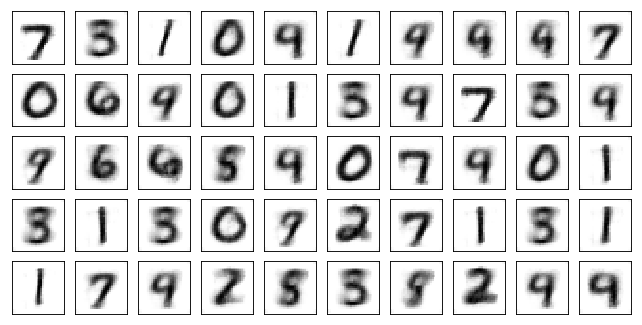

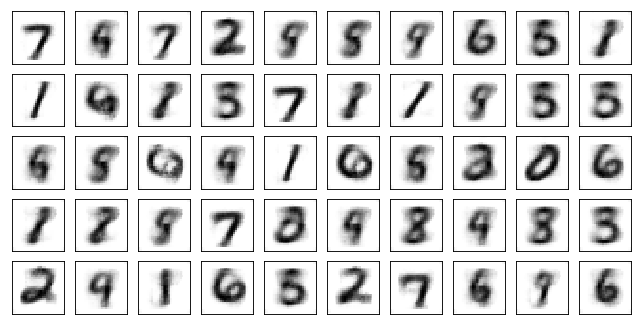

Test losses: VAE2: 0.1762/4.0578
Train Epoch: 22 [0/50000 (0%)]	Losses VAE2: 0.1848
Train Epoch: 22 [10000/50000 (20%)]	Losses VAE2: 0.1837
Train Epoch: 22 [20000/50000 (40%)]	Losses VAE2: 0.1775
Train Epoch: 22 [30000/50000 (60%)]	Losses VAE2: 0.1743
Train Epoch: 22 [40000/50000 (80%)]	Losses VAE2: 0.1950
Train Epoch: 22 [50000/50000 (100%)]	Losses VAE2: 0.1791


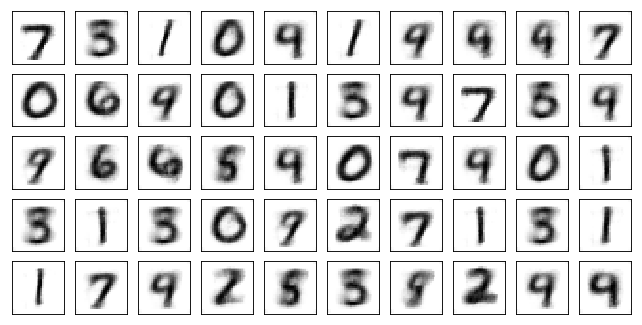

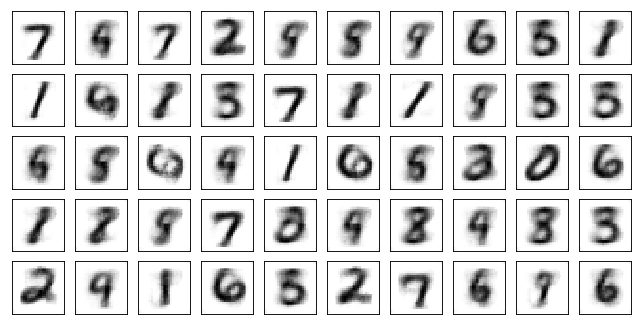

Test losses: VAE2: 0.1756/4.1241
Train Epoch: 23 [0/50000 (0%)]	Losses VAE2: 0.1903
Train Epoch: 23 [10000/50000 (20%)]	Losses VAE2: 0.1791
Train Epoch: 23 [20000/50000 (40%)]	Losses VAE2: 0.1710
Train Epoch: 23 [30000/50000 (60%)]	Losses VAE2: 0.1857
Train Epoch: 23 [40000/50000 (80%)]	Losses VAE2: 0.1805
Train Epoch: 23 [50000/50000 (100%)]	Losses VAE2: 0.1925


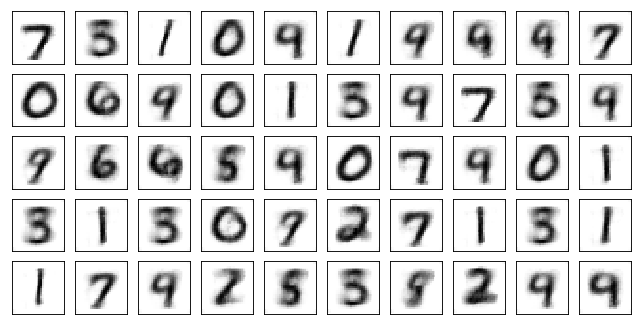

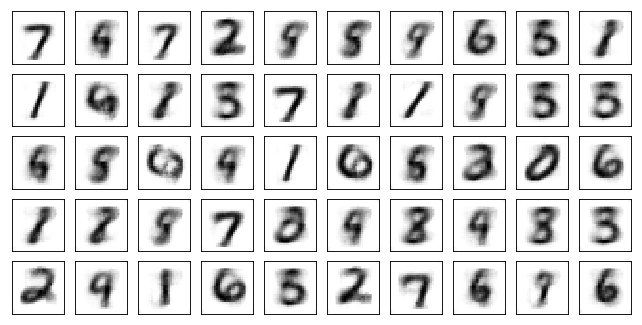

Test losses: VAE2: 0.1748/4.1280
Train Epoch: 24 [0/50000 (0%)]	Losses VAE2: 0.1871
Train Epoch: 24 [10000/50000 (20%)]	Losses VAE2: 0.1659
Train Epoch: 24 [20000/50000 (40%)]	Losses VAE2: 0.1676
Train Epoch: 24 [30000/50000 (60%)]	Losses VAE2: 0.1860
Train Epoch: 24 [40000/50000 (80%)]	Losses VAE2: 0.1825
Train Epoch: 24 [50000/50000 (100%)]	Losses VAE2: 0.1775


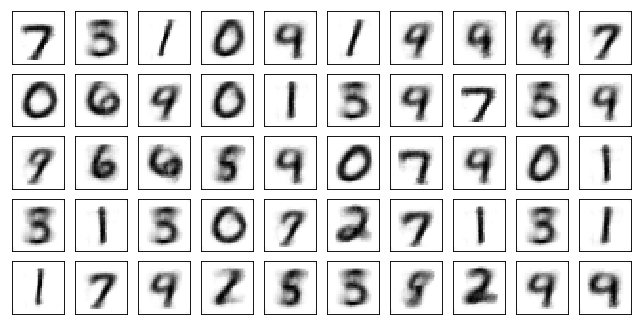

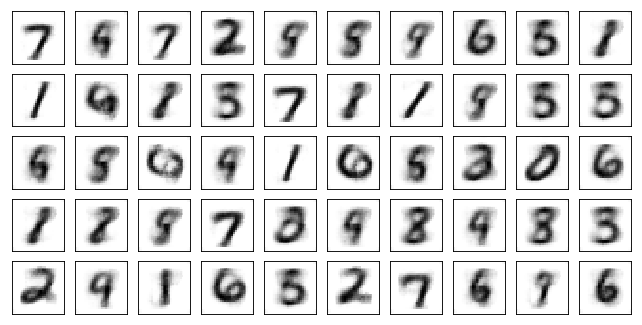

Test losses: VAE2: 0.1742/4.1637
Train Epoch: 25 [0/50000 (0%)]	Losses VAE2: 0.1785
Train Epoch: 25 [10000/50000 (20%)]	Losses VAE2: 0.1664
Train Epoch: 25 [20000/50000 (40%)]	Losses VAE2: 0.1643
Train Epoch: 25 [30000/50000 (60%)]	Losses VAE2: 0.1826
Train Epoch: 25 [40000/50000 (80%)]	Losses VAE2: 0.1795
Train Epoch: 25 [50000/50000 (100%)]	Losses VAE2: 0.1612


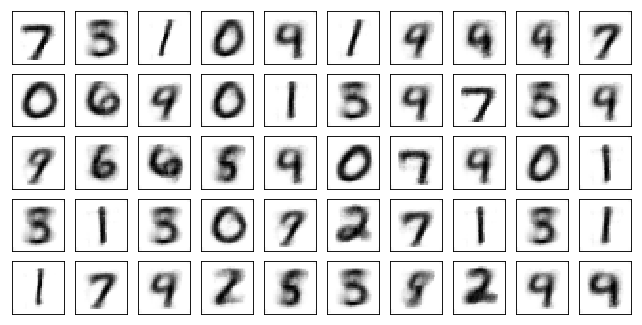

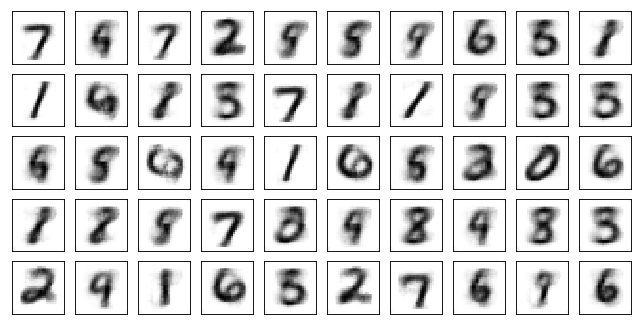

Test losses: VAE2: 0.1736/4.2449
Train Epoch: 26 [0/50000 (0%)]	Losses VAE2: 0.1753
Train Epoch: 26 [10000/50000 (20%)]	Losses VAE2: 0.1752
Train Epoch: 26 [20000/50000 (40%)]	Losses VAE2: 0.1829
Train Epoch: 26 [30000/50000 (60%)]	Losses VAE2: 0.2023
Train Epoch: 26 [40000/50000 (80%)]	Losses VAE2: 0.1891
Train Epoch: 26 [50000/50000 (100%)]	Losses VAE2: 0.1702


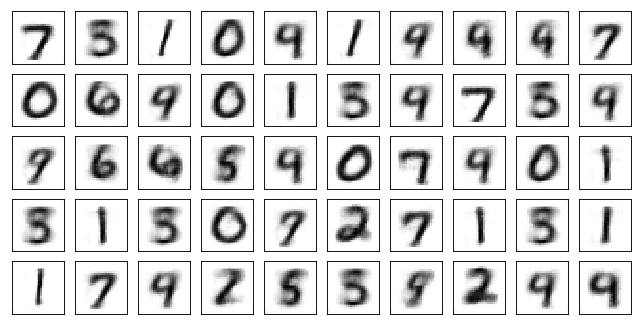

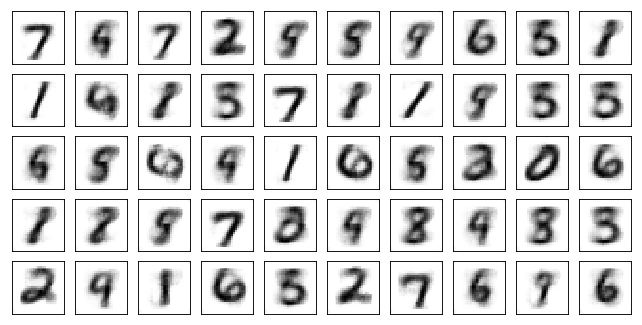

Test losses: VAE2: 0.1734/4.1881
Train Epoch: 27 [0/50000 (0%)]	Losses VAE2: 0.1672
Train Epoch: 27 [10000/50000 (20%)]	Losses VAE2: 0.1690
Train Epoch: 27 [20000/50000 (40%)]	Losses VAE2: 0.1958
Train Epoch: 27 [30000/50000 (60%)]	Losses VAE2: 0.1649
Train Epoch: 27 [40000/50000 (80%)]	Losses VAE2: 0.1725
Train Epoch: 27 [50000/50000 (100%)]	Losses VAE2: 0.1836


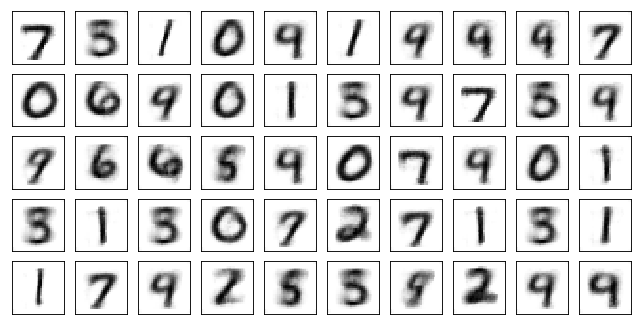

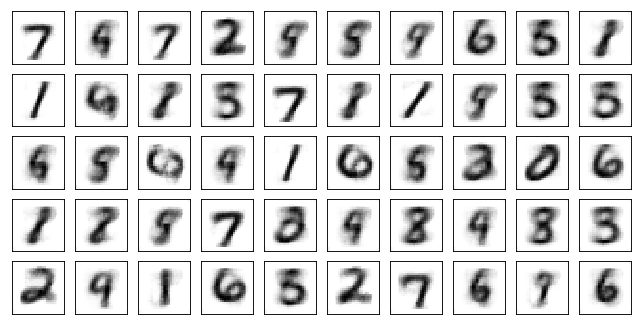

Test losses: VAE2: 0.1725/4.3345
Train Epoch: 28 [0/50000 (0%)]	Losses VAE2: 0.1794
Train Epoch: 28 [10000/50000 (20%)]	Losses VAE2: 0.1634
Train Epoch: 28 [20000/50000 (40%)]	Losses VAE2: 0.1943
Train Epoch: 28 [30000/50000 (60%)]	Losses VAE2: 0.1740
Train Epoch: 28 [40000/50000 (80%)]	Losses VAE2: 0.1769
Train Epoch: 28 [50000/50000 (100%)]	Losses VAE2: 0.1778


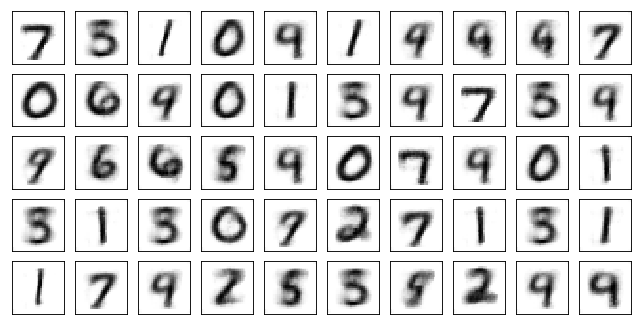

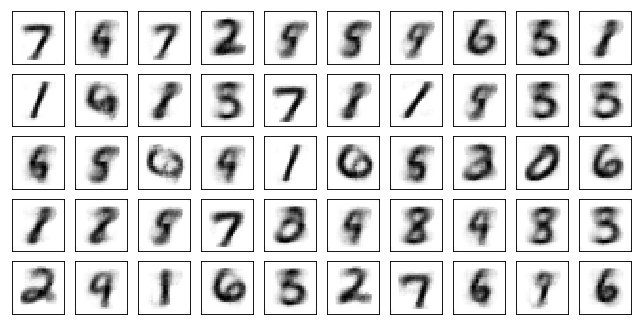

Test losses: VAE2: 0.1722/4.2926
Train Epoch: 29 [0/50000 (0%)]	Losses VAE2: 0.1872
Train Epoch: 29 [10000/50000 (20%)]	Losses VAE2: 0.1881
Train Epoch: 29 [20000/50000 (40%)]	Losses VAE2: 0.1732
Train Epoch: 29 [30000/50000 (60%)]	Losses VAE2: 0.1717
Train Epoch: 29 [40000/50000 (80%)]	Losses VAE2: 0.1908
Train Epoch: 29 [50000/50000 (100%)]	Losses VAE2: 0.1832


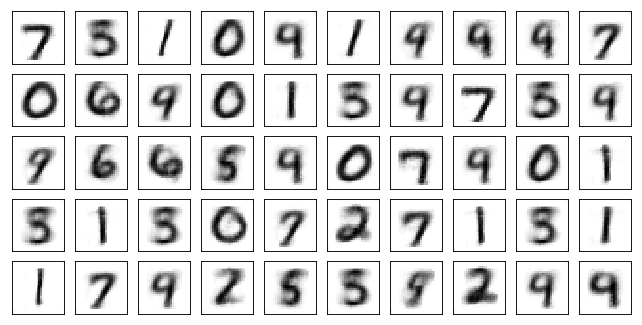

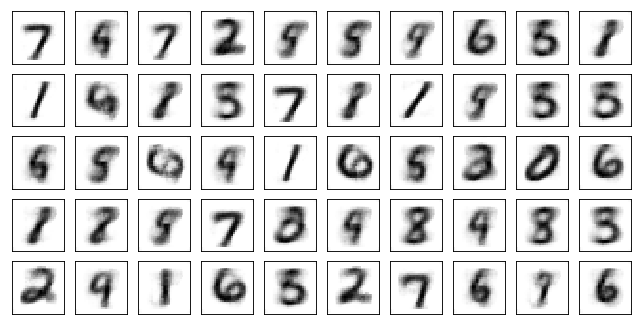

Test losses: VAE2: 0.1720/4.2480
Train Epoch: 30 [0/50000 (0%)]	Losses VAE2: 0.1721
Train Epoch: 30 [10000/50000 (20%)]	Losses VAE2: 0.1413
Train Epoch: 30 [20000/50000 (40%)]	Losses VAE2: 0.1627
Train Epoch: 30 [30000/50000 (60%)]	Losses VAE2: 0.1913
Train Epoch: 30 [40000/50000 (80%)]	Losses VAE2: 0.1966
Train Epoch: 30 [50000/50000 (100%)]	Losses VAE2: 0.1837


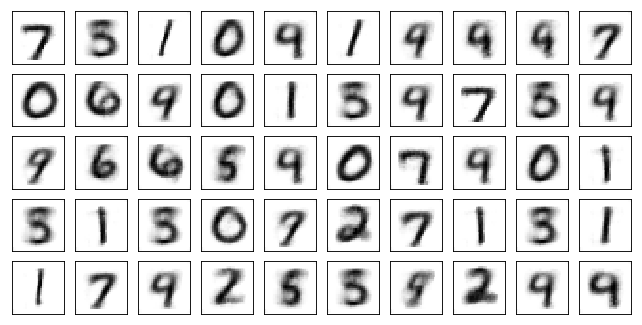

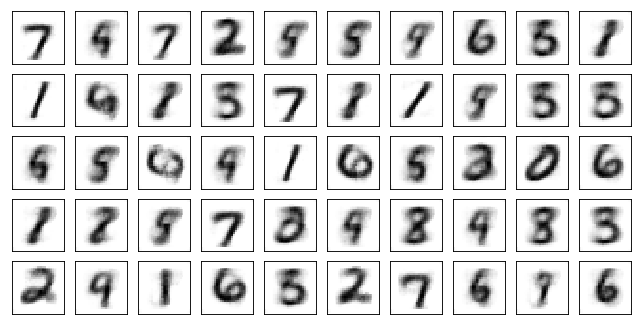

Test losses: VAE2: 0.1712/4.4181


In [26]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

# Визуализация двумерного VAE

In [125]:
ae2 = models['VAE2']

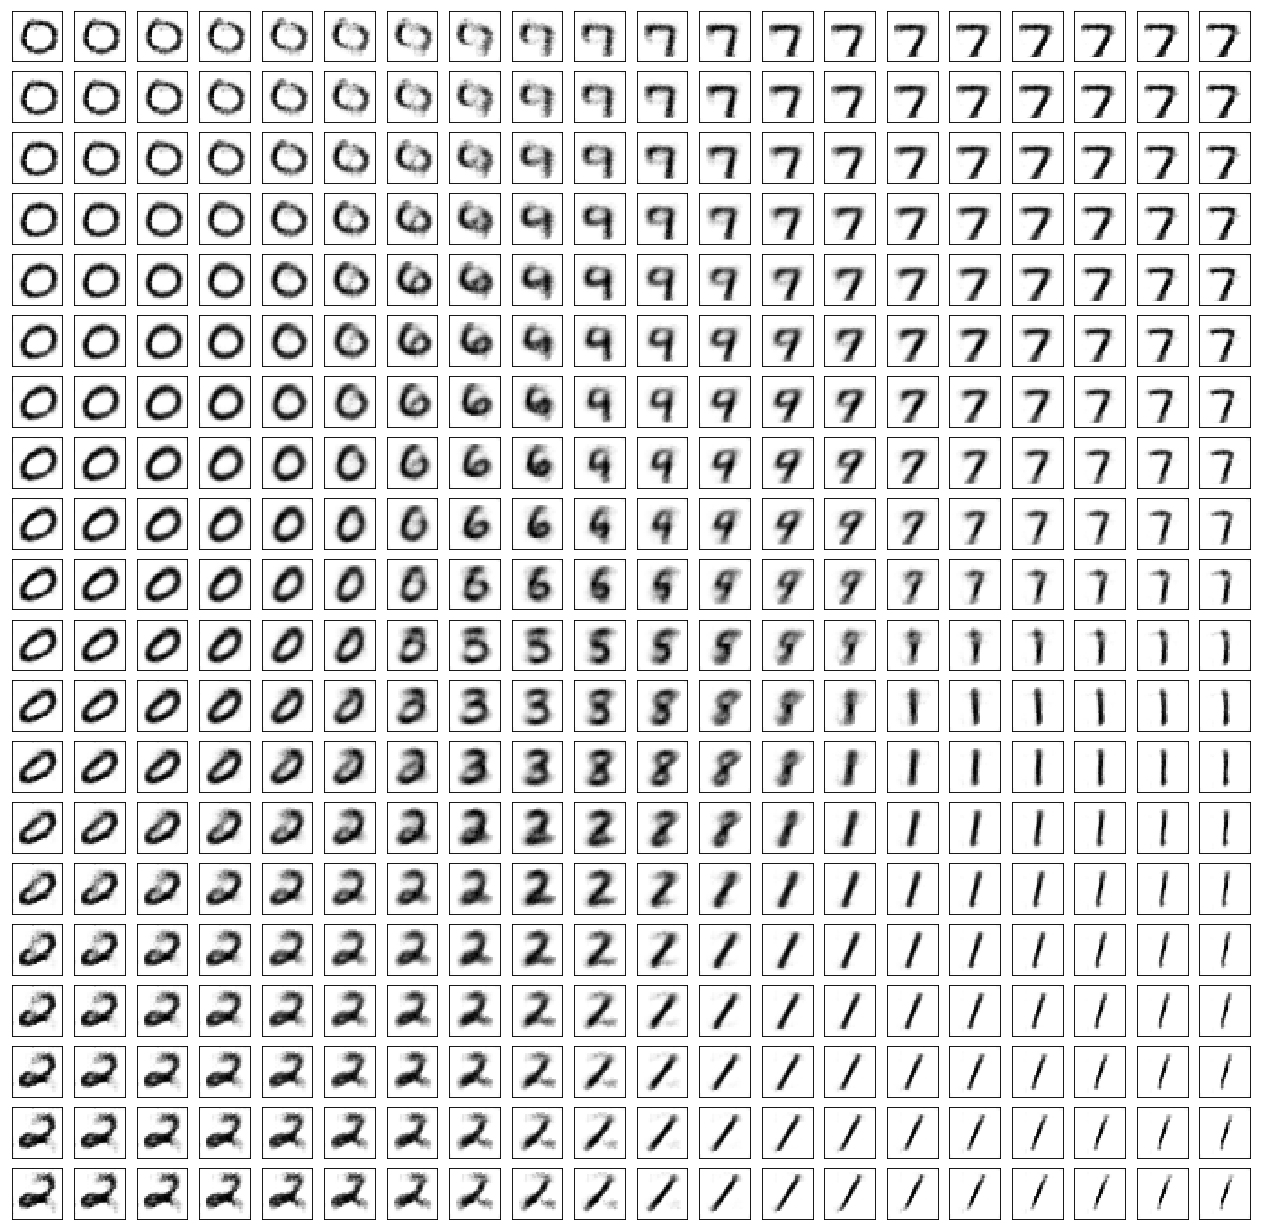

In [133]:
images = []

cells = np.linspace(-3, 3, num=20)

for x in cells:
    for y in cells:
        images.append(ae2.decode(torch.Tensor([x, y])).data.numpy())

images = np.array(images).reshape(-1, 1, 28, 28)
plot_mnist(images, (len(cells), len(cells)))

# Условный VAE

In [181]:
class Net(nn.Module):
    def __init__(self, latent_size=32, target_size=10, gamma=1e-3, batchnorm=False, dropout=False, optim_type='SGD', **optim_params):
        super(Net, self).__init__()
    
        self.latent_size = latent_size
        self.gamma = gamma
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        self.fcd = FullyConnected([latent_size+target_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x, y):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        x = self.decode(torch.cat((h, y), 1))
        return x
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size])
    
    def loss(self, output, target, size_average=True):
        KLD = self.mu**2 + self.logvar.exp() - 1 - self.logvar
        KLD = 0.5*KLD.sum(1)
        if size_average:
            self.KLD = KLD.mean()
            self._loss = F.mse_loss(output, target, reduction='mean')
        else:
            self.KLD = KLD.sum()
            self._loss = F.mse_loss(output, target, reduction='sum')
        
        return self._loss + self.gamma*self.KLD

In [182]:
models = {'CondVAE': Net(20, 10, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [183]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            ohe_target = torch.eye(10)[target]
            output = model(data, ohe_target)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [193]:
fixed_z = torch.randn((50, 30))

In [194]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            ohe_target = torch.eye(10)[target]
            output = {k: m(data, ohe_target) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()
    
    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k, 
                                                                    test_reconstruction_loss[k], 
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ohe_fixed_target = torch.eye(10)[fixed_target]
            ae_data = models[k](fixed_data, ohe_fixed_target).data.numpy()
            fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses CondVAE: 0.1545
Train Epoch: 1 [10000/50000 (20%)]	Losses CondVAE: 0.1582
Train Epoch: 1 [20000/50000 (40%)]	Losses CondVAE: 0.1445
Train Epoch: 1 [30000/50000 (60%)]	Losses CondVAE: 0.1543
Train Epoch: 1 [40000/50000 (80%)]	Losses CondVAE: 0.1372
Train Epoch: 1 [50000/50000 (100%)]	Losses CondVAE: 0.1429


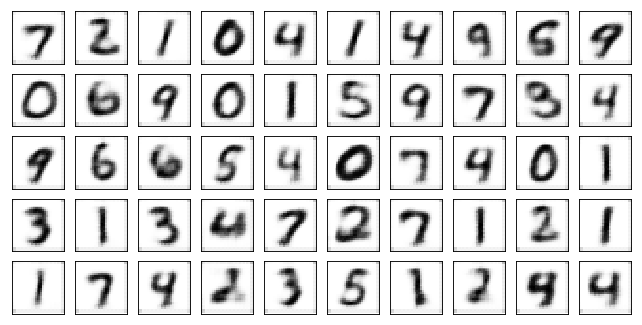

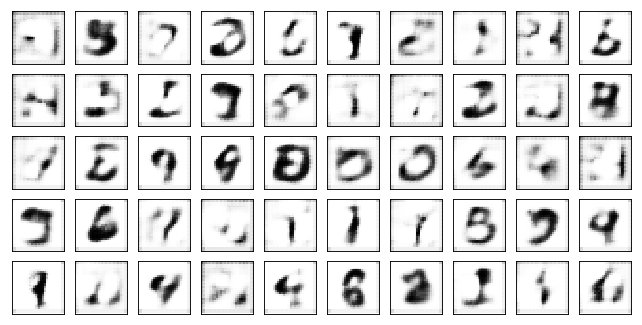

Test losses: CondVAE: 0.1148/7.7649
Train Epoch: 2 [0/50000 (0%)]	Losses CondVAE: 0.1403
Train Epoch: 2 [10000/50000 (20%)]	Losses CondVAE: 0.1413
Train Epoch: 2 [20000/50000 (40%)]	Losses CondVAE: 0.1350
Train Epoch: 2 [30000/50000 (60%)]	Losses CondVAE: 0.1368
Train Epoch: 2 [40000/50000 (80%)]	Losses CondVAE: 0.1338
Train Epoch: 2 [50000/50000 (100%)]	Losses CondVAE: 0.1313


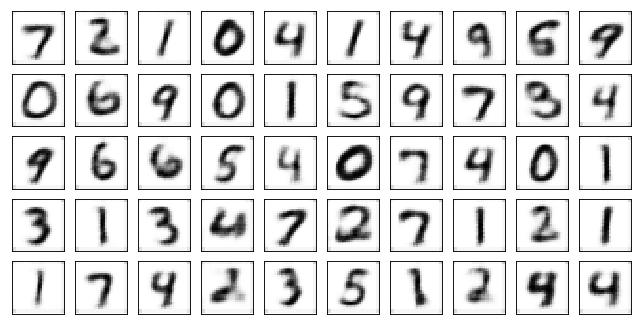

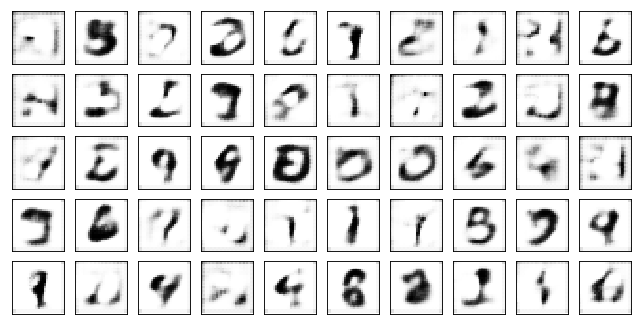

Test losses: CondVAE: 0.1061/7.9208
Train Epoch: 3 [0/50000 (0%)]	Losses CondVAE: 0.1207
Train Epoch: 3 [10000/50000 (20%)]	Losses CondVAE: 0.1311
Train Epoch: 3 [20000/50000 (40%)]	Losses CondVAE: 0.1199
Train Epoch: 3 [30000/50000 (60%)]	Losses CondVAE: 0.1254
Train Epoch: 3 [40000/50000 (80%)]	Losses CondVAE: 0.1194
Train Epoch: 3 [50000/50000 (100%)]	Losses CondVAE: 0.1260


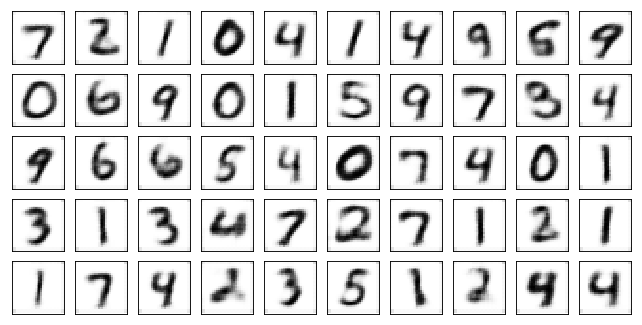

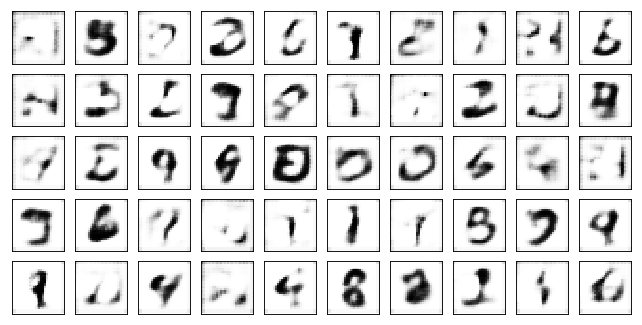

Test losses: CondVAE: 0.1002/8.2151
Train Epoch: 4 [0/50000 (0%)]	Losses CondVAE: 0.1167
Train Epoch: 4 [10000/50000 (20%)]	Losses CondVAE: 0.1250
Train Epoch: 4 [20000/50000 (40%)]	Losses CondVAE: 0.1381
Train Epoch: 4 [30000/50000 (60%)]	Losses CondVAE: 0.1193
Train Epoch: 4 [40000/50000 (80%)]	Losses CondVAE: 0.1201
Train Epoch: 4 [50000/50000 (100%)]	Losses CondVAE: 0.1217


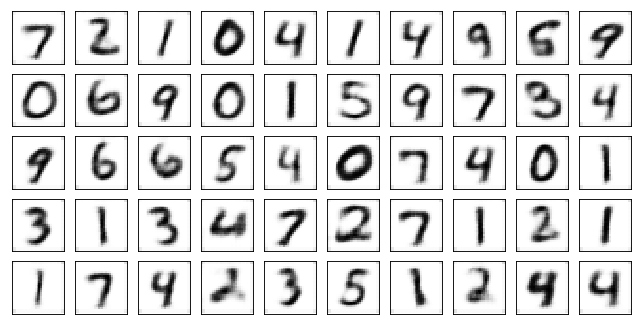

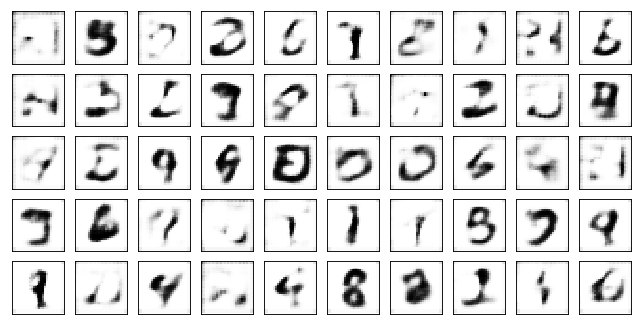

Test losses: CondVAE: 0.0957/8.3831
Train Epoch: 5 [0/50000 (0%)]	Losses CondVAE: 0.1144
Train Epoch: 5 [10000/50000 (20%)]	Losses CondVAE: 0.1151
Train Epoch: 5 [20000/50000 (40%)]	Losses CondVAE: 0.1156
Train Epoch: 5 [30000/50000 (60%)]	Losses CondVAE: 0.1214
Train Epoch: 5 [40000/50000 (80%)]	Losses CondVAE: 0.1236
Train Epoch: 5 [50000/50000 (100%)]	Losses CondVAE: 0.1133


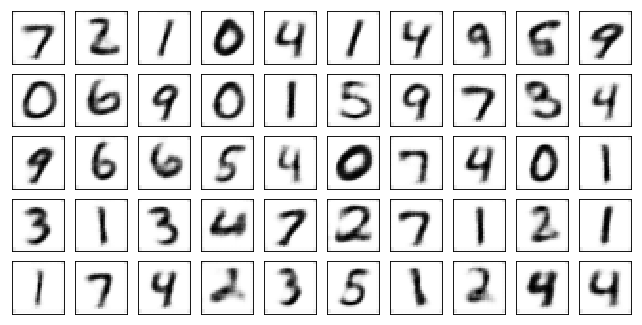

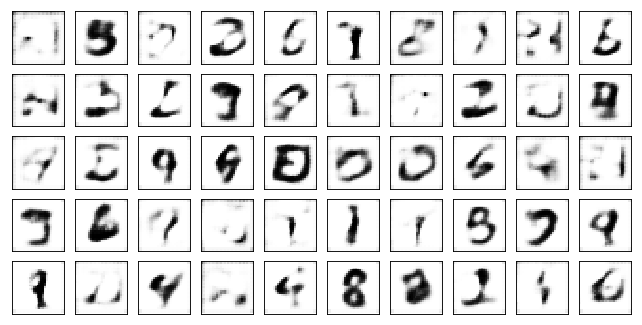

Test losses: CondVAE: 0.0923/8.5466
Train Epoch: 6 [0/50000 (0%)]	Losses CondVAE: 0.1244
Train Epoch: 6 [10000/50000 (20%)]	Losses CondVAE: 0.1159
Train Epoch: 6 [20000/50000 (40%)]	Losses CondVAE: 0.1265
Train Epoch: 6 [30000/50000 (60%)]	Losses CondVAE: 0.1137
Train Epoch: 6 [40000/50000 (80%)]	Losses CondVAE: 0.1229
Train Epoch: 6 [50000/50000 (100%)]	Losses CondVAE: 0.1207


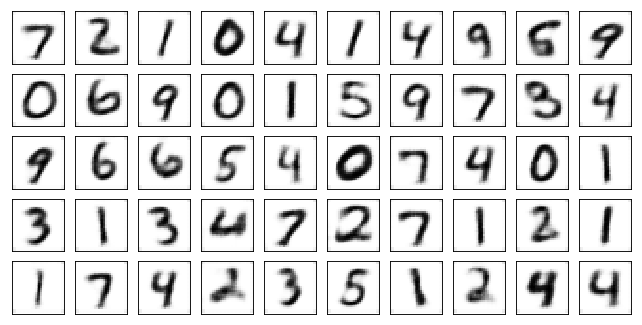

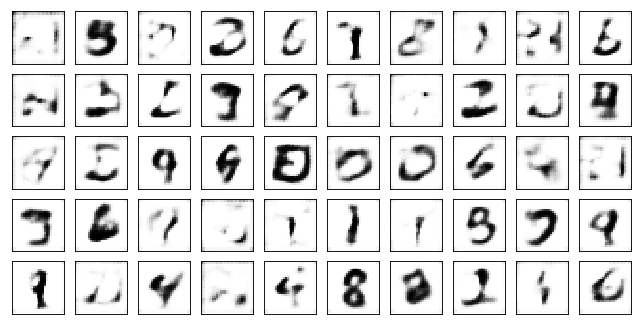

Test losses: CondVAE: 0.0897/8.5530
Train Epoch: 7 [0/50000 (0%)]	Losses CondVAE: 0.1253
Train Epoch: 7 [10000/50000 (20%)]	Losses CondVAE: 0.1160
Train Epoch: 7 [20000/50000 (40%)]	Losses CondVAE: 0.1063
Train Epoch: 7 [30000/50000 (60%)]	Losses CondVAE: 0.1201
Train Epoch: 7 [40000/50000 (80%)]	Losses CondVAE: 0.1165
Train Epoch: 7 [50000/50000 (100%)]	Losses CondVAE: 0.1055


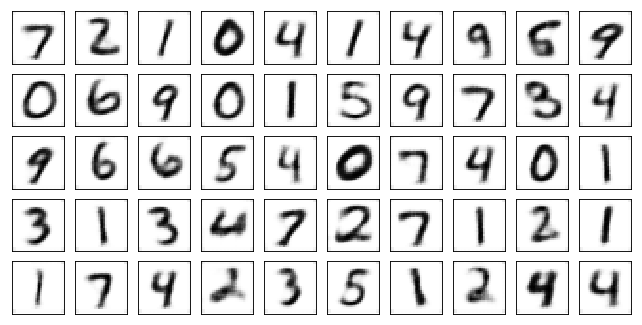

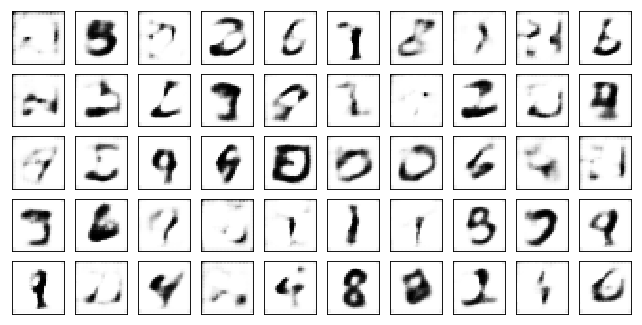

Test losses: CondVAE: 0.0880/8.6291
Train Epoch: 8 [0/50000 (0%)]	Losses CondVAE: 0.1111
Train Epoch: 8 [10000/50000 (20%)]	Losses CondVAE: 0.1093
Train Epoch: 8 [20000/50000 (40%)]	Losses CondVAE: 0.1249
Train Epoch: 8 [30000/50000 (60%)]	Losses CondVAE: 0.1140
Train Epoch: 8 [40000/50000 (80%)]	Losses CondVAE: 0.1088
Train Epoch: 8 [50000/50000 (100%)]	Losses CondVAE: 0.1101


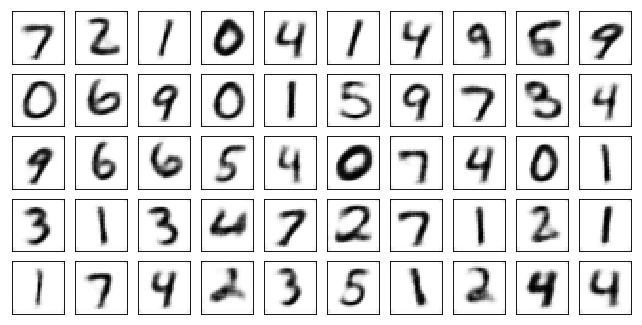

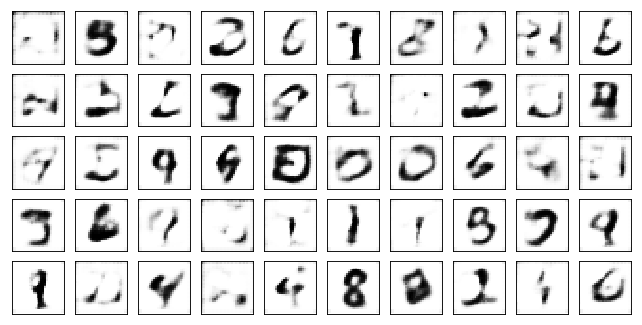

Test losses: CondVAE: 0.0860/8.8060
Train Epoch: 9 [0/50000 (0%)]	Losses CondVAE: 0.1061
Train Epoch: 9 [10000/50000 (20%)]	Losses CondVAE: 0.1120
Train Epoch: 9 [20000/50000 (40%)]	Losses CondVAE: 0.1095
Train Epoch: 9 [30000/50000 (60%)]	Losses CondVAE: 0.1026
Train Epoch: 9 [40000/50000 (80%)]	Losses CondVAE: 0.1119
Train Epoch: 9 [50000/50000 (100%)]	Losses CondVAE: 0.1114


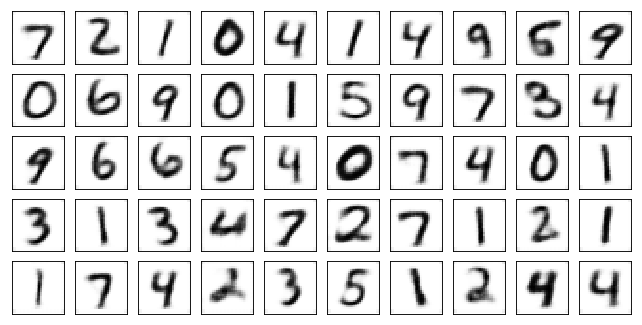

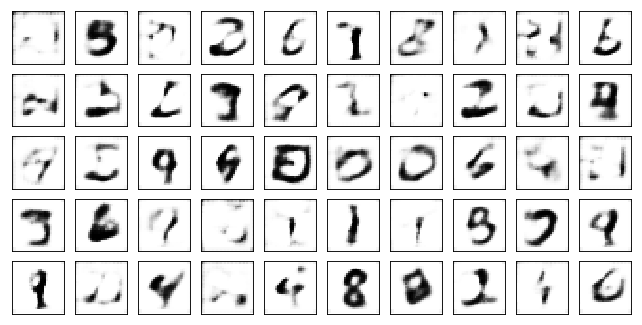

Test losses: CondVAE: 0.0843/8.9296
Train Epoch: 10 [0/50000 (0%)]	Losses CondVAE: 0.1048
Train Epoch: 10 [10000/50000 (20%)]	Losses CondVAE: 0.1112
Train Epoch: 10 [20000/50000 (40%)]	Losses CondVAE: 0.1028
Train Epoch: 10 [30000/50000 (60%)]	Losses CondVAE: 0.1023
Train Epoch: 10 [40000/50000 (80%)]	Losses CondVAE: 0.1211
Train Epoch: 10 [50000/50000 (100%)]	Losses CondVAE: 0.1213


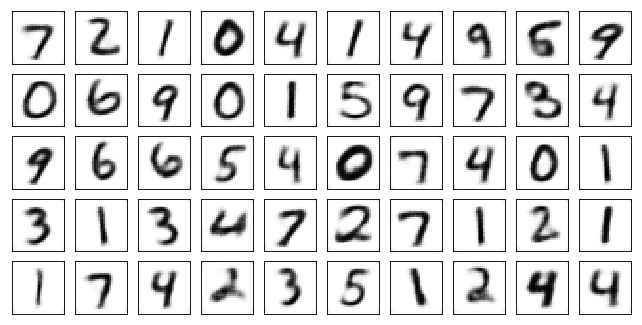

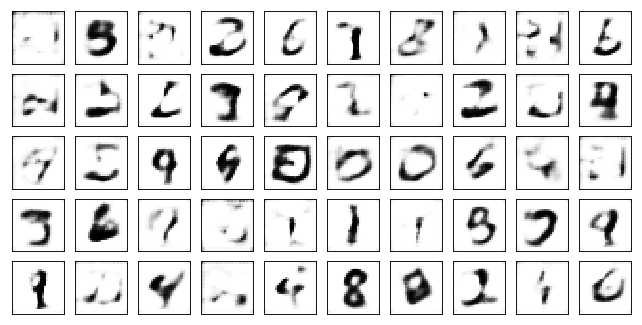

Test losses: CondVAE: 0.0834/8.9836
Train Epoch: 11 [0/50000 (0%)]	Losses CondVAE: 0.1132
Train Epoch: 11 [10000/50000 (20%)]	Losses CondVAE: 0.1146
Train Epoch: 11 [20000/50000 (40%)]	Losses CondVAE: 0.1043
Train Epoch: 11 [30000/50000 (60%)]	Losses CondVAE: 0.1010
Train Epoch: 11 [40000/50000 (80%)]	Losses CondVAE: 0.1063
Train Epoch: 11 [50000/50000 (100%)]	Losses CondVAE: 0.1151


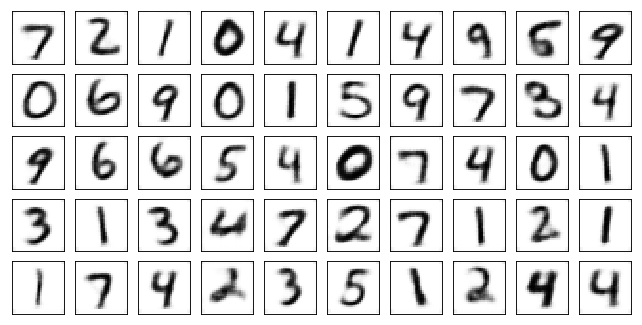

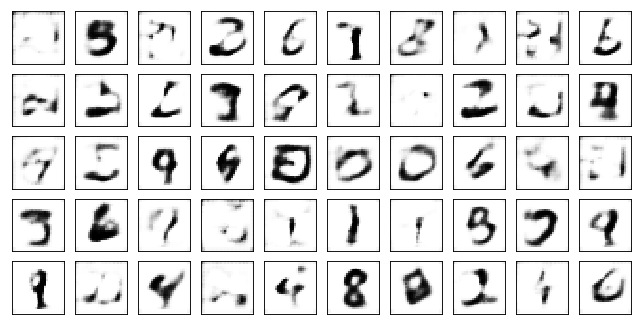

Test losses: CondVAE: 0.0821/8.7970
Train Epoch: 12 [0/50000 (0%)]	Losses CondVAE: 0.1006
Train Epoch: 12 [10000/50000 (20%)]	Losses CondVAE: 0.1058
Train Epoch: 12 [20000/50000 (40%)]	Losses CondVAE: 0.1101
Train Epoch: 12 [30000/50000 (60%)]	Losses CondVAE: 0.1075
Train Epoch: 12 [40000/50000 (80%)]	Losses CondVAE: 0.0999
Train Epoch: 12 [50000/50000 (100%)]	Losses CondVAE: 0.1078


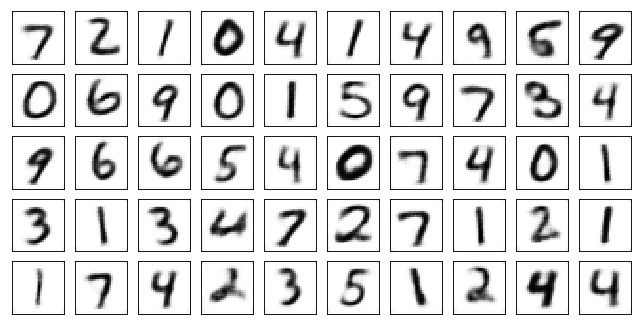

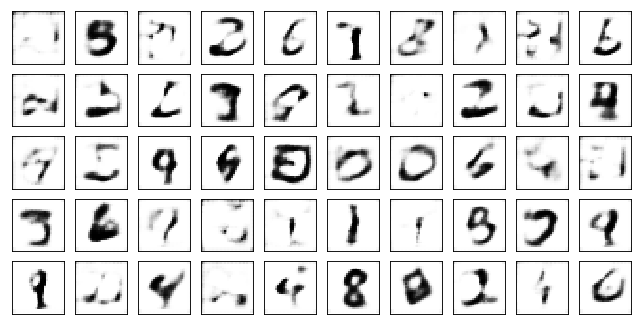

Test losses: CondVAE: 0.0808/9.0695
Train Epoch: 13 [0/50000 (0%)]	Losses CondVAE: 0.1128
Train Epoch: 13 [10000/50000 (20%)]	Losses CondVAE: 0.1112
Train Epoch: 13 [20000/50000 (40%)]	Losses CondVAE: 0.1032
Train Epoch: 13 [30000/50000 (60%)]	Losses CondVAE: 0.1050
Train Epoch: 13 [40000/50000 (80%)]	Losses CondVAE: 0.1126
Train Epoch: 13 [50000/50000 (100%)]	Losses CondVAE: 0.1037


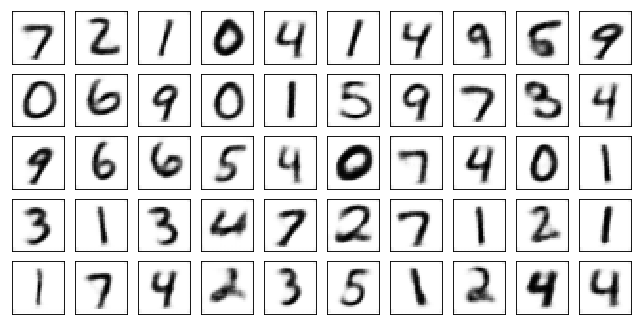

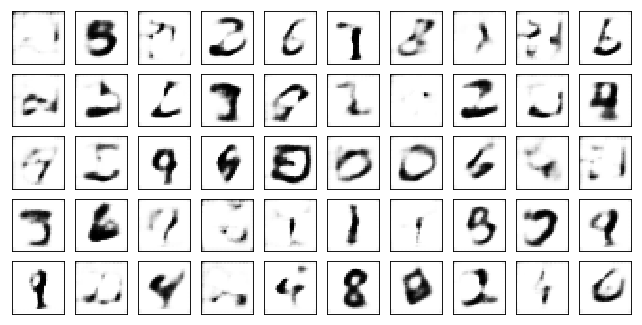

Test losses: CondVAE: 0.0800/8.9565
Train Epoch: 14 [0/50000 (0%)]	Losses CondVAE: 0.0976
Train Epoch: 14 [10000/50000 (20%)]	Losses CondVAE: 0.0959
Train Epoch: 14 [20000/50000 (40%)]	Losses CondVAE: 0.1089
Train Epoch: 14 [30000/50000 (60%)]	Losses CondVAE: 0.1029
Train Epoch: 14 [40000/50000 (80%)]	Losses CondVAE: 0.1042
Train Epoch: 14 [50000/50000 (100%)]	Losses CondVAE: 0.1014


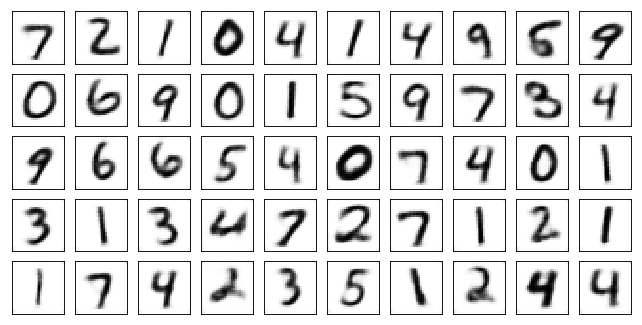

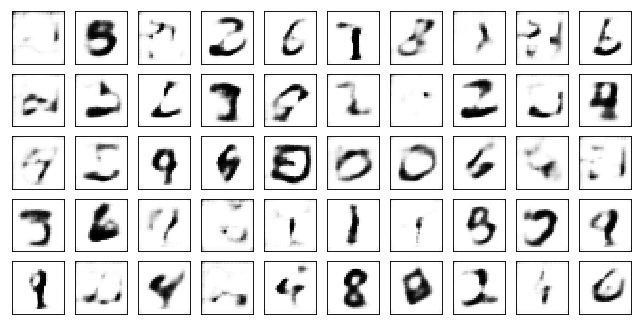

Test losses: CondVAE: 0.0798/9.0488
Train Epoch: 15 [0/50000 (0%)]	Losses CondVAE: 0.1101
Train Epoch: 15 [10000/50000 (20%)]	Losses CondVAE: 0.1113
Train Epoch: 15 [20000/50000 (40%)]	Losses CondVAE: 0.1154
Train Epoch: 15 [30000/50000 (60%)]	Losses CondVAE: 0.1121
Train Epoch: 15 [40000/50000 (80%)]	Losses CondVAE: 0.1123
Train Epoch: 15 [50000/50000 (100%)]	Losses CondVAE: 0.1071


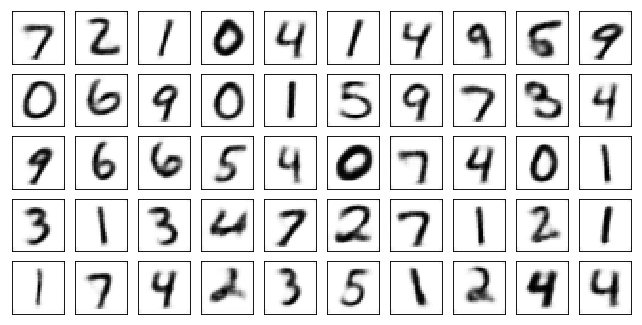

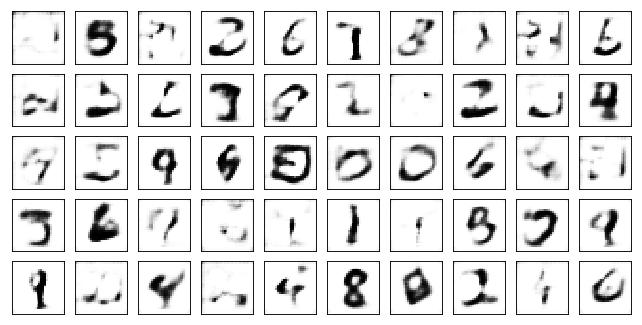

Test losses: CondVAE: 0.0785/9.0678


In [195]:
for epoch in range(1, 16):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

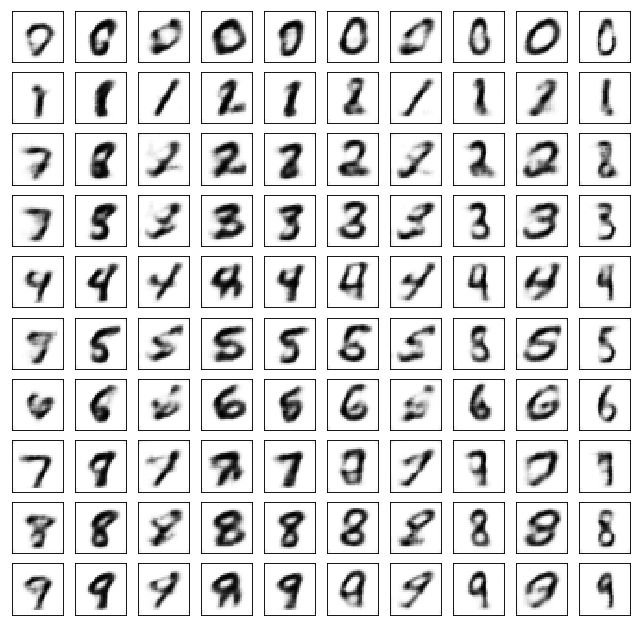

In [229]:
ae20 = models['CondVAE']
images = []
target = torch.eye(10)
sampled = torch.randn((10, 20))

for c in range(len(target)):
    for sample in range(len(sampled)):
        cond = torch.cat((sampled[sample, :], target[c, :]), 0)
        images.append(ae20.decode(cond).data.numpy())

images = np.array(images).reshape(-1, 1, 28, 28)
plot_mnist(images, (10, 10))